In [1]:
%load_ext autoreload
%autoreload 2

# Results

In [2]:
import os
import re
import itertools
from tqdm import tqdm
import warnings

import numpy as np
import pandas as pd
from scipy import stats

import torch
from torch.nn import functional as F

import sklearn.metrics as metrics
import sklearn.preprocessing as prep

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.colors import rgb_to_hsv,hsv_to_rgb, to_rgb

from library import architectures, tools, evals, dataset, losses

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

### Functions

In [3]:
def custom_sat_cmap(basecolor, num, min_s=0.001):

    hsv = rgb_to_hsv(basecolor).tolist()
    new_s_lst = np.linspace(min_s, hsv[1], num)

    new_cmap = []
    for new_s in new_s_lst:
        hsv[1] = new_s
        new_cmap.append(hsv_to_rgb(hsv).tolist())

    return new_cmap

In [4]:
def list_model_files(folder_path):
    # List to store .model files
    model_files = []

    # Iterate over all files in the given folder
    for file_name in os.listdir(folder_path):
        # Check if the file ends with .model
        if file_name.endswith('.model'):
            model_files.append(file_name)

    return model_files


In [5]:
def get_training_log(log_path, log_item = 'Loss/train'):
    # log_path = f"./_models/{scale}/_s42/{arch}/{approach}/Logs"
    onlyfiles = [f for f in os.listdir(log_path) if os.path.isfile(os.path.join(log_path, f))]
    log_file = onlyfiles[-1]

    event_acc = EventAccumulator(os.path.join(log_path, log_file))
    event_acc.Reload()

    logs = [e.value for e in event_acc.Scalars(log_item)]

    return logs

## Small-scale experiments

### Initialize

#### Variables

In [6]:
SCALE = 'SmallScale'
training_info = tools.load_yaml('./config/train.yaml')

approaches_abbr = {'SoftMax':'SM','EOS':'EOS','OvR':'OvR','OpenSetOvR':'OSOvR'}
approaches_full = {'SoftMax':'SoftMax Loss','EOS':'Enropic Open-Set Loss','OvR':'One-vs-Rest Loss','OpenSetOvR':'Open-Set OvR Loss'}
seeds = [42,43,44,45,46,47,48,49,50,51]
num_classes = 10

CMAP = mpl.color_sequences['tab10']
CMAP_L = mpl.color_sequences['tab20b']
CMAP_C = mpl.color_sequences['Set3']
CMAP_H = mpl.colors.LinearSegmentedColormap.from_list("", ['gray','white']),

#### Evaluation data from SM

In [7]:
CATEGORY = '_RQ1'

ARCHITECTURE = 'LeNet'   
sm_data_info_1 = [
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}', 'SoftMax'], 'label': 'SM'},
]

ARCHITECTURE = 'LeNet_plus_plus'   
sm_plus_data_info_1 = [
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}', 'SoftMax'], 'label': 'SM'},
]
sm_plus_data_info_1_01 = [
    # {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_0-1-neg-0', 'SoftMax'], 'label': 'SM (w/o neg)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_nclass_2', 'SoftMax'], 'label': 'SM'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_nclass_3', 'SoftMax'], 'label': 'SM'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_nclass_4', 'SoftMax'], 'label': 'SM'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_nclass_5', 'SoftMax'], 'label': 'SM'},
]

In [8]:
CATEGORY = '_Discussion'

ARCHITECTURE = 'LeNet'   
sm_data_info_D = [
    {'info':[f"{SCALE}", CATEGORY, f'{ARCHITECTURE}_feats_2', 'SoftMax'], 'label': 'SM (fdim = 2)'},
    {'info':[f"{SCALE}", CATEGORY, f'{ARCHITECTURE}_feats_5', 'SoftMax'], 'label': 'SM (fdim = 5)'},
    {'info':[f"{SCALE}", CATEGORY, f'{ARCHITECTURE}_feats_10', 'SoftMax'], 'label': 'SM (fdim = 10)'},
    {'info':[f"{SCALE}", CATEGORY, f'{ARCHITECTURE}_feats_100', 'SoftMax'], 'label': 'SM (fdim = 100)'},
    {'info':[SCALE, '_RQ1', f'{ARCHITECTURE}', 'SoftMax'], 'label': 'SM (fdim = 500)'},
]

#### Evaluation data from EOS

In [9]:
CATEGORY = '_RQ1'

ARCHITECTURE = 'LeNet'   
eos_data_info_1 = [
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}', 'EOS'], 'label': 'EOS'},
]

ARCHITECTURE = 'LeNet_plus_plus'   
eos_plus_data_info_1 = [
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}', 'EOS'], 'label': 'EOS'},
]
eos_plus_data_info_1_01 = [
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_nclass_2', 'EOS'], 'label': 'EOS'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_nclass_3', 'EOS'], 'label': 'EOS'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_nclass_4', 'EOS'], 'label': 'EOS'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_nclass_5', 'EOS'], 'label': 'EOS'},
]

In [10]:
CATEGORY = '_RQ2'

ARCHITECTURE = 'LeNet'          
eos_data_info_2 = [
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_neg_0', 'EOS'], 'label': 'EOS (w/o neg)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_neg_1k', 'EOS'], 'label': 'EOS (w/ neg 1k)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_neg_5k', 'EOS'], 'label': 'EOS (w/ neg 5k)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_neg_10k', 'EOS'], 'label': 'EOS (w/ neg 10k)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_neg_20k', 'EOS'], 'label': 'EOS (w/ neg 20k)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_neg_30k', 'EOS'], 'label': 'EOS (w/ neg 30k)'},
    {'info':[SCALE, '_RQ1', f'{ARCHITECTURE}', 'EOS'], 'label': 'EOS (w/ neg all)'},
]

ARCHITECTURE = 'LeNet_plus_plus'          
eos_plus_data_info_2 = [
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_neg_0', 'EOS'], 'label': 'EOS (w/o neg)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_neg_1k', 'EOS'], 'label': 'EOS (w/ neg 1k)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_neg_5k', 'EOS'], 'label': 'EOS (w/ neg 5k)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_neg_10k', 'EOS'], 'label': 'EOS (w/ neg 10k)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_neg_20k', 'EOS'], 'label': 'EOS (w/ neg 20k)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_neg_30k', 'EOS'], 'label': 'EOS (w/ neg 30k)'},
    {'info':[SCALE, '_RQ1', f'{ARCHITECTURE}', 'EOS'], 'label': 'EOS (w/ neg all)'},
]

In [11]:
CATEGORY = '_Discussion'

ARCHITECTURE = 'LeNet'   
eos_data_info_D = [
    {'info':[f"{SCALE}", CATEGORY, f'{ARCHITECTURE}_feats_2', 'EOS'], 'label': 'EOS (fdim = 2)'},
    {'info':[f"{SCALE}", CATEGORY, f'{ARCHITECTURE}_feats_5', 'EOS'], 'label': 'EOS (fdim = 5)'},
    {'info':[f"{SCALE}", CATEGORY, f'{ARCHITECTURE}_feats_10', 'EOS'], 'label': 'EOS (fdim = 10)'},
    {'info':[f"{SCALE}", CATEGORY, f'{ARCHITECTURE}_feats_100', 'EOS'], 'label': 'EOS (fdim = 100)'},
    {'info':[SCALE, '_RQ1', f'{ARCHITECTURE}', 'EOS'], 'label': 'EOS (fdim = 500)'},
]

#### Evaluation data from OvR

In [12]:
CATEGORY = '_RQ1'

ARCHITECTURE = 'LeNet'   
ovr_data_info_1 = [
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}', 'OvR'], 'label': 'OvR'},
]

In [13]:
CATEGORY = '_RQ2'

ARCHITECTURE = 'LeNet'          
ovr_data_info_2 = [
    {'info':[SCALE, '_RQ1', f'{ARCHITECTURE}', 'OvR'], 'label': 'OvR (w/o neg)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_neg_1k', 'OvR'], 'label': 'OvR (w/ neg 1k)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_neg_5k', 'OvR'], 'label': 'OvR (w/ neg 5k)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_neg_10k', 'OvR'], 'label': 'OvR (w/ neg 10k)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_neg_20k', 'OvR'], 'label': 'OvR (w/ neg 20k)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_neg_30k', 'OvR'], 'label': 'OvR (w/ neg 30k)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_neg_All', 'OvR'], 'label': 'OvR (w/ neg all)'},
]

In [14]:
CATEGORY = '_RQ3'
ARCHITECTURE = 'LeNet'            # LeNet_plus_plus       LeNet

ovr_data_info_3_C = [
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_C_b', 'OvR'], 'label': 'OvR-C (Batch)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_C_g', 'OvR'], 'label': 'OvR-C (Global)'},
]
ovr_data_info_3_F = [
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_F_02', 'OvR'], 'label': 'OvR-F (0.2)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_F_06', 'OvR'], 'label': 'OvR-F (0.6)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_F_1', 'OvR'], 'label': 'OvR-F (1)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_F_2', 'OvR'], 'label': 'OvR-F (2)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_F_3', 'OvR'], 'label': 'OvR-F (3)'},
]

ovr_data_info_3_M = [
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_M_0', 'OvR'], 'label': 'OvR-M (0)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_M_02', 'OvR'], 'label': 'OvR-M (0.2)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_M_04', 'OvR'], 'label': 'OvR-M (0.4)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_M_06', 'OvR'], 'label': 'OvR-M (0.6)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_M_08', 'OvR'], 'label': 'OvR-M (0.8)'},
]

ovr_data_info_3_FCM = [
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_CF_b_06', 'OvR'], 'label': 'OvR-CF'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_CM_b_02', 'OvR'], 'label': 'OvR-CM'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_FM_06_02', 'OvR'], 'label': 'OvR-FM'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_CFM_b_06_02', 'OvR'], 'label': 'OvR-CFM'},
]

In [15]:
CATEGORY = '_Discussion'

ARCHITECTURE = 'LeNet_plus_plus'   
ovr_data_info_D = [
    {'info':[f"{SCALE}", CATEGORY, f'{ARCHITECTURE}_F2C2', 'OvR'], 'label': 'OvR (#F=2, #C=2, w/o neg)'},
    {'info':[f"{SCALE}", CATEGORY, f'{ARCHITECTURE}_F2C5', 'OvR'], 'label': 'OvR (#F=2, #C=5, w/o neg)'},
    {'info':[f"{SCALE}", CATEGORY, f'{ARCHITECTURE}_F2C10', 'OvR'], 'label': 'OvR (#F=2, #C=10, w/o neg)'},
    {'info':[f"{SCALE}", CATEGORY, f'{ARCHITECTURE}_F3C3', 'OvR'], 'label': 'OvR (#F=3, #C=3, w/o neg)'},
    {'info':[f"{SCALE}", CATEGORY, f'{ARCHITECTURE}_F3C4', 'OvR'], 'label': 'OvR (#F=3, #C=4, w/o neg)'},
    {'info':[f"{SCALE}", CATEGORY, f'{ARCHITECTURE}_F2C2_neg_All', 'OvR'], 'label': 'OvR (#F=2, #C=2, w/ neg)'},
    {'info':[f"{SCALE}", CATEGORY, f'{ARCHITECTURE}_F2C5_neg_All', 'OvR'], 'label': 'OvR (#F=2, #C=5, w/ neg)'},
    {'info':[f"{SCALE}", CATEGORY, f'{ARCHITECTURE}_F2C10_neg_All', 'OvR'], 'label': 'OvR (#F=2, #C=10, w/ neg)'},
    {'info':[f"{SCALE}", CATEGORY, f'{ARCHITECTURE}_F3C3_neg_All', 'OvR'], 'label': 'OvR (#F=3, #C=3, w/ neg)'},
    {'info':[f"{SCALE}", CATEGORY, f'{ARCHITECTURE}_F3C4_neg_All', 'OvR'], 'label': 'OvR (#F=3, #C=4, w/ neg)'},
]

#### Evaluation data from OSOvR

In [16]:
CATEGORY = '_Tuning'

ARCHITECTURE = 'LeNet'   
osovr_data_info_T = [
    {'info':[f"{SCALE}", CATEGORY, f'{ARCHITECTURE}_sigma_5', 'OpenSetOvR'], 'label': 'OSOvR (5)'},
    {'info':[f"{SCALE}", CATEGORY, f'{ARCHITECTURE}_sigma_6', 'OpenSetOvR'], 'label': 'OSOvR (6)'},
    {'info':[f"{SCALE}", CATEGORY, f'{ARCHITECTURE}_sigma_8', 'OpenSetOvR'], 'label': 'OSOvR (8)'},
    {'info':[f"{SCALE}", CATEGORY, f'{ARCHITECTURE}_sigma_12', 'OpenSetOvR'], 'label': 'OSOvR (12)'},
]

In [17]:
CATEGORY = '_RQ1'

ARCHITECTURE = 'LeNet'   
osovr_data_info_1 = [
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}', 'OpenSetOvR'], 'label': 'OSOvR'},
]


In [18]:
CATEGORY = '_RQ2'

ARCHITECTURE = 'LeNet'          
osovr_data_info_2 = [
    {'info':[SCALE, '_RQ1', f'{ARCHITECTURE}', 'OpenSetOvR'], 'label': 'OSOvR (w/o neg)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_neg_1k', 'OpenSetOvR'], 'label': 'OSOvR (w/ neg 1k)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_neg_5k', 'OpenSetOvR'], 'label': 'OSOvR (w/ neg 5k)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_neg_10k', 'OpenSetOvR'], 'label': 'OSOvR (w/ neg 10k)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_neg_20k', 'OpenSetOvR'], 'label': 'OSOvR (w/ neg 20k)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_neg_30k', 'OpenSetOvR'], 'label': 'OSOvR (w/ neg 30k)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_neg_All', 'OpenSetOvR'], 'label': 'OSOvR (w/ neg all)'},
]

In [19]:
CATEGORY = '_RQ3'
ARCHITECTURE = 'LeNet'            # LeNet_plus_plus       LeNet

osovr_data_info_3_C = [
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_C_b', 'OpenSetOvR'], 'label': 'OSOvR-C (Batch)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_C_g', 'OpenSetOvR'], 'label': 'OSOvR-C (Global)'},
]
osovr_data_info_3_F = [
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_F_02', 'OpenSetOvR'], 'label': 'OSOvR-F (0.2)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_F_06', 'OpenSetOvR'], 'label': 'OSOvR-F (0.6)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_F_1', 'OpenSetOvR'], 'label': 'OSOvR-F (1)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_F_2', 'OpenSetOvR'], 'label': 'OSOvR-F (2)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_F_3', 'OpenSetOvR'], 'label': 'OSOvR-F (3)'},
]

osovr_data_info_3_M = [
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_M_0', 'OpenSetOvR'], 'label': 'OSOvR-M (0)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_M_02', 'OpenSetOvR'], 'label': 'OSOvR-M (0.2)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_M_04', 'OpenSetOvR'], 'label': 'OSOvR-M (0.4)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_M_06', 'OpenSetOvR'], 'label': 'OSOvR-M (0.6)'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_M_08', 'OpenSetOvR'], 'label': 'OSOvR-M (0.8)'},
]

osovr_data_info_3_FCM = [
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_CF_g_06', 'OpenSetOvR'], 'label': 'OSOvR-CF'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_CM_g_0', 'OpenSetOvR'], 'label': 'OSOvR-CM'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_FM_06_0', 'OpenSetOvR'], 'label': 'OSOvR-FM'},
    {'info':[SCALE, CATEGORY, f'{ARCHITECTURE}_CFM_g_06_0', 'OpenSetOvR'], 'label': 'OSOvR-CFM'},
]

In [20]:
CATEGORY = '_Discussion'

ARCHITECTURE = 'LeNet_plus_plus'   
osovr_data_info_D = [
    {'info':[f"{SCALE}", CATEGORY, f'{ARCHITECTURE}_F2C2', 'OpenSetOvR'], 'label': 'OSOvR (#F=2, #C=2, w/o neg)'},
    {'info':[f"{SCALE}", CATEGORY, f'{ARCHITECTURE}_F2C5', 'OpenSetOvR'], 'label': 'OSOvR (#F=2, #C=5, w/o neg)'},
    {'info':[f"{SCALE}", CATEGORY, f'{ARCHITECTURE}_F2C10', 'OpenSetOvR'], 'label': 'OSOvR (#F=2, #C=10, w/o neg)'},
    {'info':[f"{SCALE}", CATEGORY, f'{ARCHITECTURE}_F3C3', 'OpenSetOvR'], 'label': 'OSOvR (#F=3, #C=3, w/o neg)'},
    {'info':[f"{SCALE}", CATEGORY, f'{ARCHITECTURE}_F3C4', 'OpenSetOvR'], 'label': 'OSOvR (#F=3, #C=4, w/o neg)'},
    {'info':[f"{SCALE}", CATEGORY, f'{ARCHITECTURE}_F2C2_neg_All', 'OpenSetOvR'], 'label': 'OSOvR (#F=2, #C=2, w/ neg)'},
    {'info':[f"{SCALE}", CATEGORY, f'{ARCHITECTURE}_F2C5_neg_All', 'OpenSetOvR'], 'label': 'OSOvR (#F=2, #C=5, w/ neg)'},
    {'info':[f"{SCALE}", CATEGORY, f'{ARCHITECTURE}_F2C10_neg_All', 'OpenSetOvR'], 'label': 'OSOvR (#F=2, #C=10, w/ neg)'},
    {'info':[f"{SCALE}", CATEGORY, f'{ARCHITECTURE}_F3C3_neg_All', 'OpenSetOvR'], 'label': 'OSOvR (#F=3, #C=3, w/ neg)'},
    {'info':[f"{SCALE}", CATEGORY, f'{ARCHITECTURE}_F3C4_neg_All', 'OpenSetOvR'], 'label': 'OSOvR (#F=3, #C=4, w/ neg)'},
]

### 0. Tuning

#### Sigma
- Best = 8

In [24]:
data_info = osovr_data_info_T

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_Tuning', 'LeNet_sigma_5', 'OpenSetOvR']
['SmallScale', '_Tuning', 'LeNet_sigma_6', 'OpenSetOvR']
['SmallScale', '_Tuning', 'LeNet_sigma_8', 'OpenSetOvR']
['SmallScale', '_Tuning', 'LeNet_sigma_12', 'OpenSetOvR']


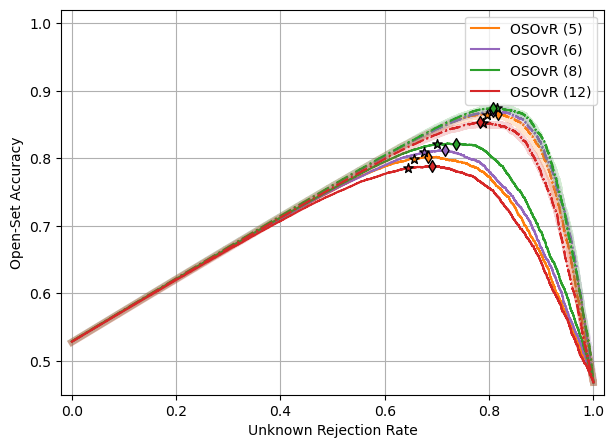

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.9944	0.9999	0.8497	0.8652	0.8648	0.7990	0.8662	0.8026
0.9938	0.9999	0.8567	0.8727	0.8698	0.8086	0.8698	0.8119
0.9943	0.9999	0.8701	0.8760	0.8743	0.8207	0.8745	0.8218
0.9935	0.9998	0.8368	0.8506	0.8529	0.7859	0.8533	0.7888


In [25]:
evals.plot_OSAC(data_info, [CMAP[1],CMAP[4],CMAP[2],CMAP[3]], figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)))
results = evals.print_metrics(data_info)

#### Loss weighting parameter
- Best C (OvR/OSOvR) : batch / batch 
- Best F (OvR/OSOvR) : 3 / 2
- Best M (OvR/OSOvR) : 0.2 / 0.4

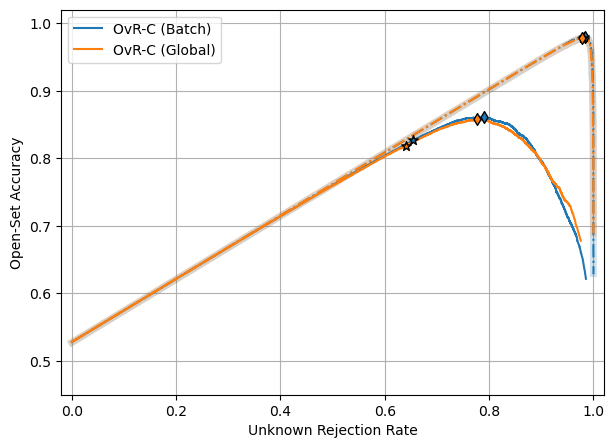

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.9928	0.9995	0.9176	0.9789	0.9799	0.8264	0.9801	0.8605
0.9929	0.9994	0.9164	0.9786	0.9777	0.8188	0.9785	0.8576


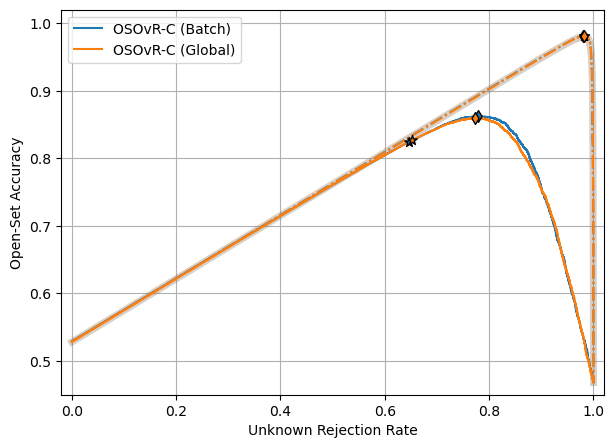

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.9942	0.9997	0.9027	0.9809	0.9811	0.8243	0.9817	0.8630
0.9931	0.9997	0.9006	0.9801	0.9808	0.8265	0.9813	0.8598


In [37]:
data_info = ovr_data_info_3_C
evals.plot_OSAC(data_info, CMAP, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)))
results = evals.print_metrics(data_info)

data_info = osovr_data_info_3_C
evals.plot_OSAC(data_info, CMAP, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)))
results = evals.print_metrics(data_info)

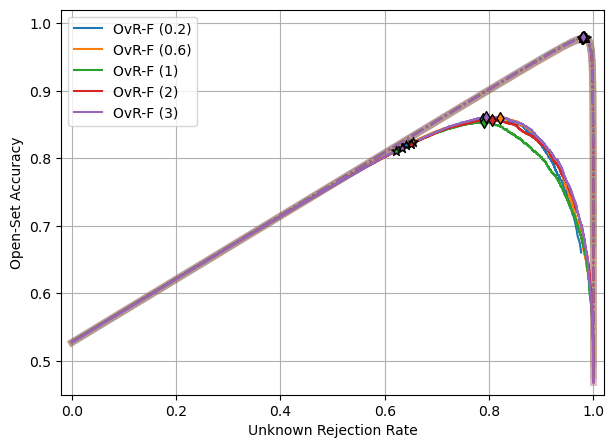

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.9934	0.9994	0.9205	0.9784	0.9790	0.8191	0.9791	0.8582
0.9936	0.9995	0.9258	0.9783	0.9774	0.8242	0.9785	0.8597
0.9933	0.9994	0.9188	0.9785	0.9780	0.8106	0.9786	0.8544
0.9920	0.9994	0.9244	0.9772	0.9778	0.8212	0.9784	0.8568
0.9920	0.9995	0.9268	0.9776	0.9783	0.8151	0.9789	0.8609


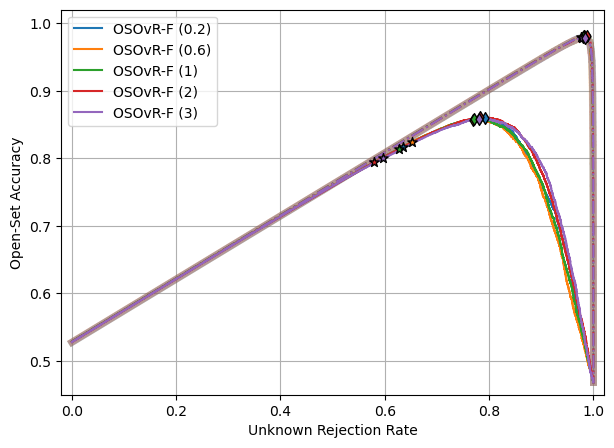

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.9932	0.9996	0.9028	0.9793	0.9808	0.8173	0.9815	0.8598
0.9937	0.9996	0.8981	0.9788	0.9800	0.8243	0.9804	0.8571
0.9940	0.9996	0.9007	0.9786	0.9798	0.8133	0.9801	0.8575
0.9926	0.9996	0.9055	0.9780	0.9792	0.7941	0.9809	0.8605
0.9927	0.9996	0.9065	0.9780	0.9787	0.8001	0.9788	0.8578


In [38]:
data_info = ovr_data_info_3_F
evals.plot_OSAC(data_info, CMAP, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)))
results = evals.print_metrics(data_info)

data_info = osovr_data_info_3_F
evals.plot_OSAC(data_info, CMAP, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)))
results = evals.print_metrics(data_info)

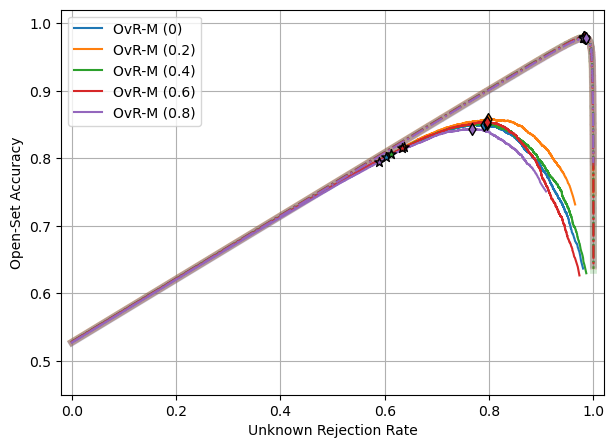

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.9928	0.9996	0.9104	0.9785	0.9797	0.8023	0.9798	0.8498
0.9922	0.9994	0.9214	0.9790	0.9784	0.8172	0.9787	0.8579
0.9937	0.9996	0.9151	0.9791	0.9797	0.8062	0.9798	0.8509
0.9927	0.9995	0.9069	0.9788	0.9786	0.8148	0.9789	0.8536
0.9911	0.9994	0.8916	0.9782	0.9782	0.7946	0.9785	0.8437


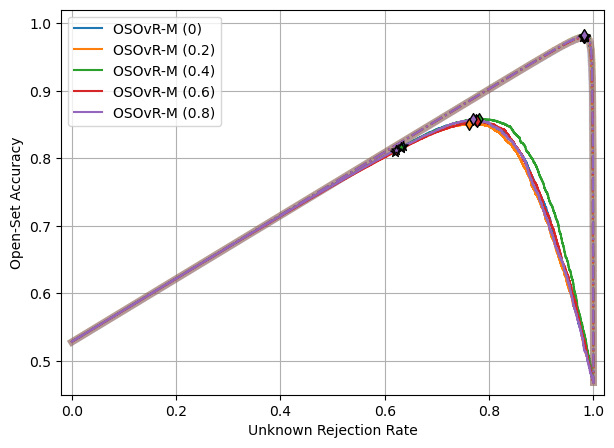

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.9936	0.9997	0.8968	0.9787	0.9797	0.8180	0.9800	0.8560
0.9935	0.9997	0.8920	0.9797	0.9798	0.8148	0.9804	0.8509
0.9941	0.9997	0.9046	0.9811	0.9807	0.8162	0.9811	0.8587
0.9937	0.9997	0.8958	0.9795	0.9794	0.8091	0.9796	0.8548
0.9939	0.9996	0.8952	0.9800	0.9813	0.8119	0.9819	0.8582


In [39]:
data_info = ovr_data_info_3_M
evals.plot_OSAC(data_info, CMAP, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)))
results = evals.print_metrics(data_info)

data_info = osovr_data_info_3_M
evals.plot_OSAC(data_info, CMAP, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)))
results = evals.print_metrics(data_info)

### 1. Softmax-based vs. OvR-based loss

In [27]:
data_info = sm_data_info_1 + ovr_data_info_1 + osovr_data_info_1

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ1', 'LeNet', 'SoftMax']
['SmallScale', '_RQ1', 'LeNet', 'OvR']
['SmallScale', '_RQ1', 'LeNet', 'OpenSetOvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn


0.9931	0.9999	0.8374	0.8497	0.8531	0.7940	0.8540	0.7954
0.9940	0.9998	0.8795	0.8670	0.8691	0.8090	0.8700	0.8098
0.9943	0.9999	0.8701	0.8760	0.8743	0.8207	0.8745	0.8218


<Figure size 500x500 with 0 Axes>

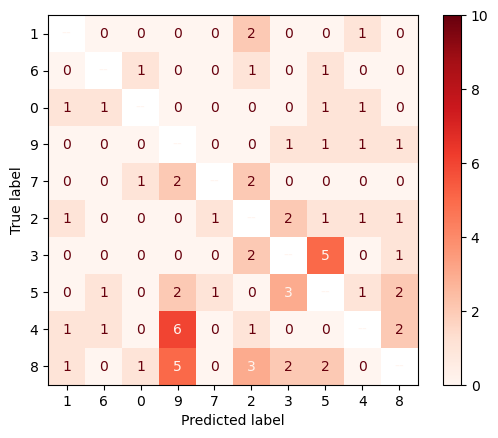

<Figure size 500x500 with 0 Axes>

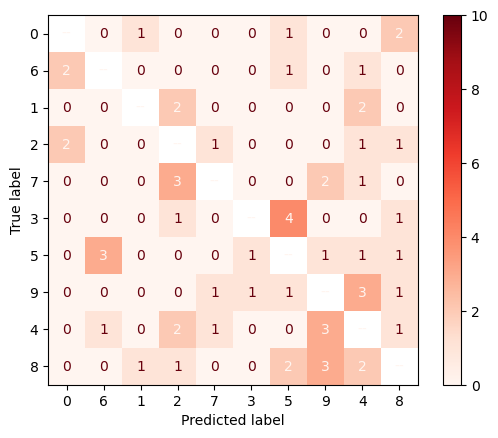

<Figure size 500x500 with 0 Axes>

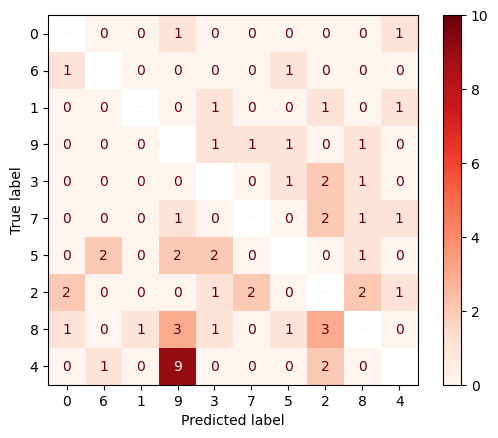

In [28]:
results = evals.print_metrics(data_info)
evals.plot_confusion_mat(data_info, colors=plt.cm.Reds,
                         set_diag_mask=True, set_cmap_range=(0,10),
                         show_numbers=True, diag_sort=True)

##### Appendix

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.9931	0.9999	0.8374	0.8497	0.8531	0.7940	0.8540	0.7954
0.9940	0.9998	0.8795	0.8670	0.8691	0.8090	0.8700	0.8098
0.9943	0.9999	0.8701	0.8760	0.8743	0.8207	0.8745	0.8218


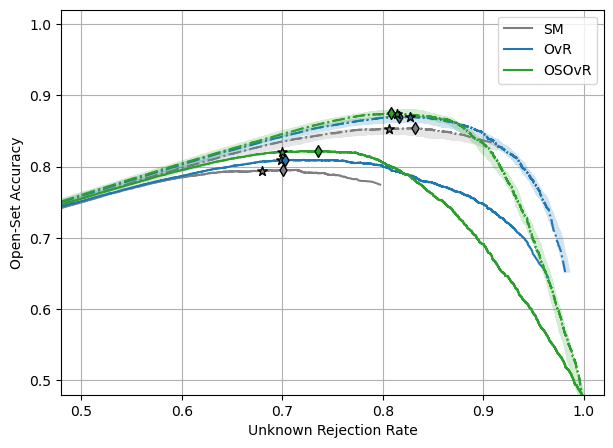

In [29]:
results = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, [CMAP[7],CMAP[0],CMAP[2]], figsize=(7,5), lim=((0.48,1.02),(0.48,1.02)))

### 2. Examine the effect of the number of negatives in training.

In [30]:
data_info = eos_data_info_2 + ovr_data_info_2 + osovr_data_info_2

FPR_vals_all = np.linspace(1e-3,1,10**4)
FPR_vals = [1e-3,1e-2,1e-1,1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

alpha = list(np.linspace(0.1,1,7,True))

['SmallScale', '_RQ2', 'LeNet_neg_0', 'EOS']
['SmallScale', '_RQ2', 'LeNet_neg_1k', 'EOS']
['SmallScale', '_RQ2', 'LeNet_neg_5k', 'EOS']
['SmallScale', '_RQ2', 'LeNet_neg_10k', 'EOS']
['SmallScale', '_RQ2', 'LeNet_neg_20k', 'EOS']
['SmallScale', '_RQ2', 'LeNet_neg_30k', 'EOS']
['SmallScale', '_RQ1', 'LeNet', 'EOS']
['SmallScale', '_RQ1', 'LeNet', 'OvR']
['SmallScale', '_RQ2', 'LeNet_neg_1k', 'OvR']
['SmallScale', '_RQ2', 'LeNet_neg_5k', 'OvR']
['SmallScale', '_RQ2', 'LeNet_neg_10k', 'OvR']
['SmallScale', '_RQ2', 'LeNet_neg_20k', 'OvR']
['SmallScale', '_RQ2', 'LeNet_neg_30k', 'OvR']
['SmallScale', '_RQ2', 'LeNet_neg_All', 'OvR']
['SmallScale', '_RQ1', 'LeNet', 'OpenSetOvR']
['SmallScale', '_RQ2', 'LeNet_neg_1k', 'OpenSetOvR']
['SmallScale', '_RQ2', 'LeNet_neg_5k', 'OpenSetOvR']
['SmallScale', '_RQ2', 'LeNet_neg_10k', 'OpenSetOvR']
['SmallScale', '_RQ2', 'LeNet_neg_20k', 'OpenSetOvR']
['SmallScale', '_RQ2', 'LeNet_neg_30k', 'OpenSetOvR']
['SmallScale', '_RQ2', 'LeNet_neg_All', 'OpenSetOv

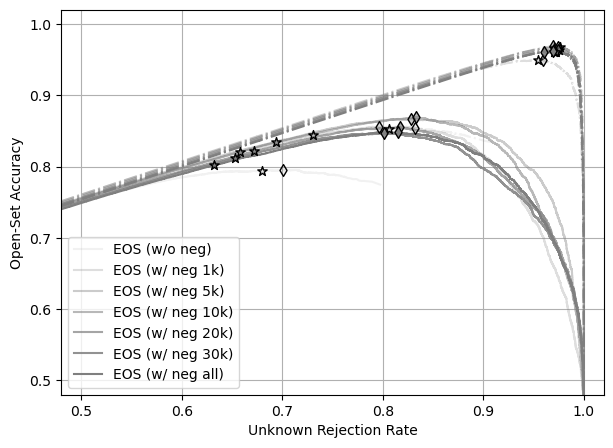

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.9931	0.9999	0.8374	0.8497	0.8531	0.7940	0.8540	0.7954
0.9912	0.9999	0.9138	0.9487	0.9491	0.8440	0.9495	0.8558
0.9907	0.9999	0.9301	0.9659	0.9673	0.8348	0.9691	0.8668
0.9868	0.9997	0.9231	0.9655	0.9666	0.8206	0.9674	0.8690
0.9830	0.9995	0.9125	0.9637	0.9636	0.8215	0.9639	0.8549
0.9796	0.9992	0.9056	0.9621	0.9606	0.8118	0.9607	0.8468
0.9774	0.9990	0.9059	0.9609	0.9613	0.8018	0.9619	0.8483


In [31]:
evals.plot_OSAC(data_info[:7], list(zip([CMAP[7]]*7,alpha)), figsize=(7,5), lim=((0.48,1.02),(0.48,1.02)), show_val=False)
results = evals.print_metrics(data_info[:7])

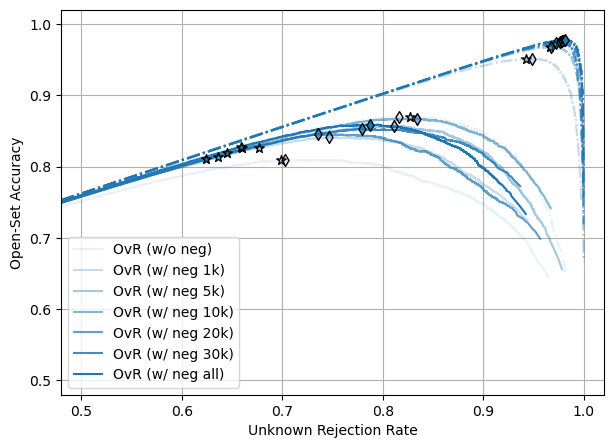

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.9940	0.9998	0.8795	0.8670	0.8691	0.8090	0.8700	0.8098
0.9940	0.9997	0.9021	0.9502	0.9509	0.8264	0.9513	0.8411
0.9926	0.9998	0.9181	0.9670	0.9680	0.8134	0.9682	0.8571
0.9939	0.9997	0.9280	0.9729	0.9735	0.8260	0.9738	0.8671
0.9922	0.9997	0.9032	0.9755	0.9742	0.8186	0.9747	0.8454
0.9936	0.9997	0.9123	0.9766	0.9763	0.8101	0.9764	0.8534
0.9931	0.9995	0.9121	0.9790	0.9778	0.8279	0.9780	0.8589


In [32]:
evals.plot_OSAC(data_info[7:14], list(zip([CMAP[0]]*7,alpha)), figsize=(7,5), lim=((0.48,1.02),(0.48,1.02)), show_val=False)
results = evals.print_metrics(data_info[7:14])

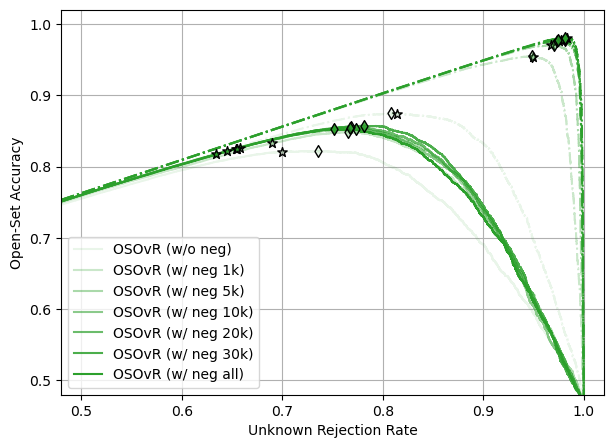

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.9943	0.9999	0.8701	0.8760	0.8743	0.8207	0.8745	0.8218
0.9944	0.9999	0.8903	0.9508	0.9541	0.8327	0.9545	0.8487
0.9942	0.9998	0.8948	0.9693	0.9707	0.8260	0.9712	0.8531
0.9940	0.9999	0.8939	0.9745	0.9757	0.8250	0.9760	0.8553
0.9938	0.9998	0.8960	0.9769	0.9779	0.8221	0.9782	0.8546
0.9935	0.9998	0.8967	0.9786	0.9771	0.8252	0.9776	0.8573
0.9939	0.9996	0.8921	0.9800	0.9804	0.8172	0.9805	0.8526


In [33]:
evals.plot_OSAC(data_info[14:], list(zip([CMAP[2]]*7,alpha)), figsize=(7,5), lim=((0.48,1.02),(0.48,1.02)), show_val=False)
results = evals.print_metrics(data_info[14:])

##### Appendix

In [34]:
data_info = eos_data_info_1[-1:] + ovr_data_info_2[-1:] + osovr_data_info_2[-1:]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ1', 'LeNet', 'EOS']
['SmallScale', '_RQ2', 'LeNet_neg_All', 'OvR']
['SmallScale', '_RQ2', 'LeNet_neg_All', 'OpenSetOvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.9774	0.9990	0.9059	0.9609	0.9613	0.8018	0.9619	0.8483
0.9931	0.9995	0.9121	0.9790	0.9778	0.8279	0.9780	0.8589
0.9939	0.9996	0.8921	0.9800	0.9804	0.8172	0.9805	0.8526


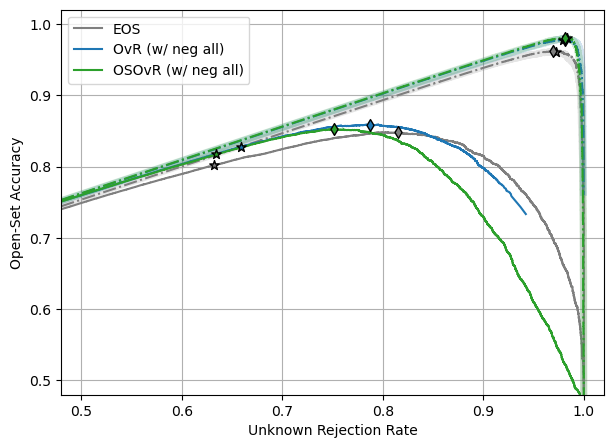

In [35]:
_data_info = data_info
results = evals.print_metrics(_data_info)
evals.plot_OSAC(data_info, [CMAP[7],CMAP[0],CMAP[2]], figsize=(7,5), lim=((0.48,1.02),(0.48,1.02)), show_val=True)

### 3. Comparing the type of loss weighting

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.9931	0.9995	0.9121	0.9790	0.9778	0.8279	0.9780	0.8589
0.9928	0.9995	0.9176	0.9789	0.9799	0.8264	0.9801	0.8605
0.9936	0.9995	0.9258	0.9783	0.9774	0.8242	0.9785	0.8597
0.9922	0.9994	0.9214	0.9790	0.9784	0.8172	0.9787	0.8579
0.9927	0.9996	0.9106	0.9769	0.9771	0.7953	0.9774	0.8434
0.9937	0.9995	0.9192	0.9785	0.9790	0.8131	0.9791	0.8549
0.9930	0.9994	0.9186	0.9777	0.9787	0.8078	0.9792	0.8507
0.9935	0.9995	0.9145	0.9778	0.9784	0.8195	0.9791	0.8526
average	std	model
0.0189	0.010	OvR (w/ neg all)
0.0162	0.009	OvR-C (Batch)
0.0130	0.005	OvR-F (0.6)
0.0192	0.010	OvR-M (0.2)
0.0184	0.018	OvR-CF
0.0153	0.011	OvR-CM
0.0200	0.014	OvR-FM
0.0149	0.009	OvR-CFM


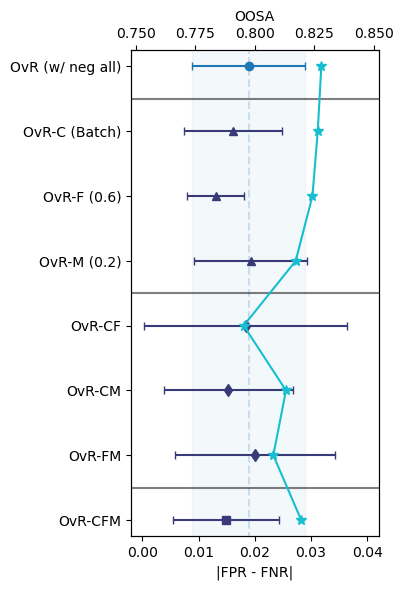

In [41]:
# data_info = eos_data_info_1[0:1]
data_info = ovr_data_info_2[-1:] + ovr_data_info_3_C[0:1] + ovr_data_info_3_F[1:2] + ovr_data_info_3_M[1:2] + ovr_data_info_3_FCM
# data_info += osovr_data_info_2[-1:] + osovr_data_info_3_C[1:] + osovr_data_info_3_F[1:2] + osovr_data_info_3_M[0:1] + osovr_data_info_3_FCM

color = [CMAP[0]] + [CMAP_L[0]]*3 + [CMAP_L[0]]*3 + [CMAP_L[0]]
marker = ['o'] + ['^']*3 + ['d']*3 + ['s']
res_ovr = evals.print_metrics(data_info)
res_ovr_fpr_fnr = evals.plot_fpr_fnr(data_info,color=color,marker=marker,figsize=(4,6),xlim=(-0.002,0.042),
                                     has_oosa={'oosa':[res['oosa_unkn'] for res in res_ovr['oosa']], 'color': CMAP[9], 'lim':(0.748,0.852)})
# evals.plot_fpr_fnr_class(data_info, color=CMAP_L[16:18], ylim=(0.0,0.1))

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.9939	0.9996	0.8921	0.9800	0.9804	0.8172	0.9805	0.8526
0.9931	0.9997	0.9006	0.9801	0.9808	0.8265	0.9813	0.8598
0.9937	0.9996	0.8981	0.9788	0.9800	0.8243	0.9804	0.8571
0.9936	0.9997	0.8968	0.9787	0.9797	0.8180	0.9800	0.8560
0.9943	0.9997	0.8926	0.9800	0.9810	0.8201	0.9810	0.8560
0.9929	0.9997	0.8985	0.9789	0.9806	0.8162	0.9809	0.8589
0.9934	0.9996	0.8986	0.9801	0.9789	0.8159	0.9799	0.8580
0.9938	0.9998	0.9000	0.9801	0.9790	0.8181	0.9795	0.8566
average	std	model
0.0178	0.012	OSOvR (w/ neg all)
0.0143	0.009	OSOvR-C (Global)
0.0157	0.013	OSOvR-F (0.6)
0.0171	0.011	OSOvR-M (0)
0.0163	0.011	OSOvR-CF
0.0150	0.010	OSOvR-CM
0.0180	0.010	OSOvR-FM
0.0154	0.009	OSOvR-CFM


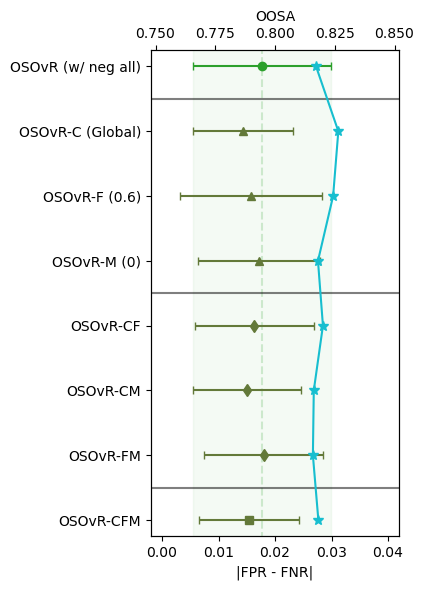

In [42]:
data_info = osovr_data_info_2[-1:] + osovr_data_info_3_C[-1:] + osovr_data_info_3_F[1:2] + osovr_data_info_3_M[0:1] + osovr_data_info_3_FCM
    
color = [CMAP[2]] + [CMAP_L[4]]*3 + [CMAP_L[4]]*3 + [CMAP_L[4]]
marker = ['o'] + ['^']*3 + ['d']*3 + ['s']
res_osovr = evals.print_metrics(data_info)
res_osovr_fpr_fnr = evals.plot_fpr_fnr(data_info,color=color,marker=marker,figsize=(4.2,6),xlim=(-0.002,0.042),
                                     has_oosa={'oosa':[res['oosa_unkn'] for res in res_osovr['oosa']], 'color': CMAP[9], 'lim':(0.748,0.852)})
# evals.plot_fpr_fnr_class(data_info, color=CMAP_L[16:18], ylim=(0.0,0.1))

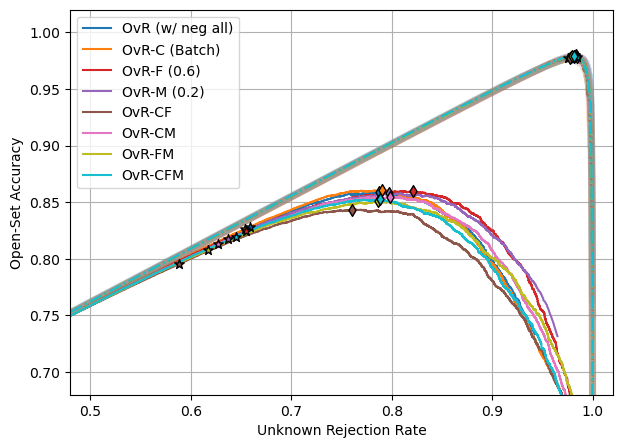

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.9931	0.9995	0.9121	0.9790	0.9778	0.8279	0.9780	0.8589
0.9928	0.9995	0.9176	0.9789	0.9799	0.8264	0.9801	0.8605
0.9936	0.9995	0.9258	0.9783	0.9774	0.8242	0.9785	0.8597
0.9922	0.9994	0.9214	0.9790	0.9784	0.8172	0.9787	0.8579
0.9927	0.9996	0.9106	0.9769	0.9771	0.7953	0.9774	0.8434
0.9937	0.9995	0.9192	0.9785	0.9790	0.8131	0.9791	0.8549
0.9930	0.9994	0.9186	0.9777	0.9787	0.8078	0.9792	0.8507
0.9935	0.9995	0.9145	0.9778	0.9784	0.8195	0.9791	0.8526


In [46]:
data_info = ovr_data_info_2[-1:] + ovr_data_info_3_C[:1] + ovr_data_info_3_F[1:2] + ovr_data_info_3_M[1:2] + ovr_data_info_3_FCM
color = [CMAP[0],CMAP[1],CMAP[3],CMAP[4],CMAP[5],CMAP[6],CMAP[8],CMAP[9],]
evals.plot_OSAC(data_info, color, figsize=(7,5), lim=((0.48,1.02),(0.68,1.02)))
res = evals.print_metrics(data_info)

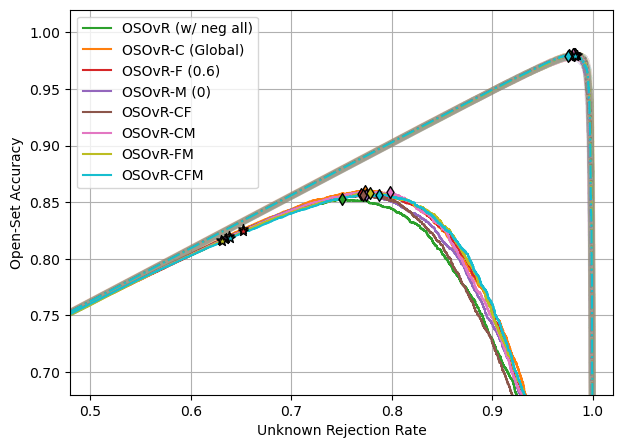

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.9939	0.9996	0.8921	0.9800	0.9804	0.8172	0.9805	0.8526
0.9931	0.9997	0.9006	0.9801	0.9808	0.8265	0.9813	0.8598
0.9937	0.9996	0.8981	0.9788	0.9800	0.8243	0.9804	0.8571
0.9936	0.9997	0.8968	0.9787	0.9797	0.8180	0.9800	0.8560
0.9943	0.9997	0.8926	0.9800	0.9810	0.8201	0.9810	0.8560
0.9929	0.9997	0.8985	0.9789	0.9806	0.8162	0.9809	0.8589
0.9934	0.9996	0.8986	0.9801	0.9789	0.8159	0.9799	0.8580
0.9938	0.9998	0.9000	0.9801	0.9790	0.8181	0.9795	0.8566


In [47]:
data_info = osovr_data_info_2[-1:] + osovr_data_info_3_C[-1:] + osovr_data_info_3_F[1:2] + osovr_data_info_3_M[:1] + osovr_data_info_3_FCM
color = [CMAP[2],CMAP[1],CMAP[3],CMAP[4],CMAP[5],CMAP[6],CMAP[8],CMAP[9],]
evals.plot_OSAC(data_info, color, figsize=(7,5), lim=((0.48,1.02),(0.68,1.02)))
res = evals.print_metrics(data_info)

#### Appendix

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn


average	std	model


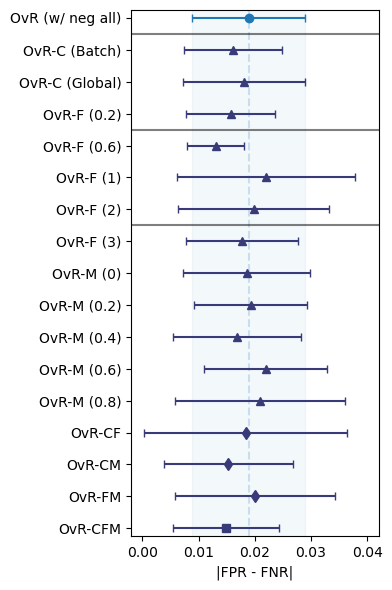

In [48]:
# data_info = eos_data_info_1[0:1]
data_info = ovr_data_info_2[-1:] + ovr_data_info_3_C + ovr_data_info_3_F + ovr_data_info_3_M + ovr_data_info_3_FCM
# data_info += osovr_data_info_2[-1:] + osovr_data_info_3_C[1:] + osovr_data_info_3_F[1:2] + osovr_data_info_3_M[0:1] + osovr_data_info_3_FCM

color = [CMAP[0]] + [CMAP_L[0]]*12 + [CMAP_L[0]]*3 + [CMAP_L[0]]
marker = ['o'] + ['^']*12 + ['d']*3 + ['s']
res_ovr = evals.print_metrics(data_info, is_verbose=False)
res_ovr_fpr_fnr = evals.plot_fpr_fnr(data_info,color=color,marker=marker,figsize=(4,6),xlim=(-0.002,0.042), is_verbose=False)
# evals.plot_fpr_fnr_class(data_info, color=CMAP_L[16:18], ylim=(0.0,0.1))

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn


average	std	model


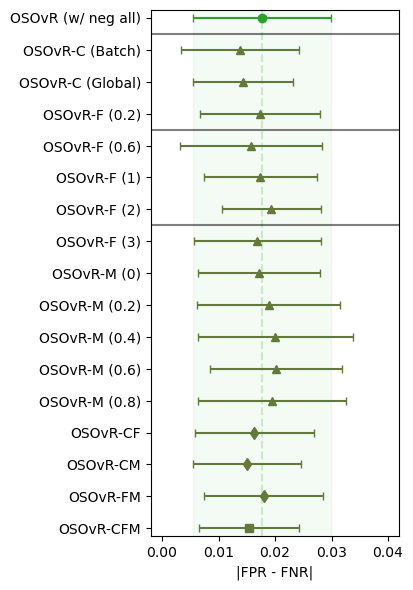

In [49]:
data_info = osovr_data_info_2[-1:] + osovr_data_info_3_C + osovr_data_info_3_F + osovr_data_info_3_M + osovr_data_info_3_FCM
    
color = [CMAP[2]] + [CMAP_L[4]]*12 + [CMAP_L[4]]*3 + [CMAP_L[4]]
marker = ['o'] + ['^']*12 + ['d']*3 + ['s']
res_osovr = evals.print_metrics(data_info, is_verbose=False)
res_osovr_fpr_fnr = evals.plot_fpr_fnr(data_info,color=color,marker=marker,figsize=(4.2,6),xlim=(-0.002,0.042), is_verbose=False)
# evals.plot_fpr_fnr_class(data_info, color=CMAP_L[16:18], ylim=(0.0,0.1))


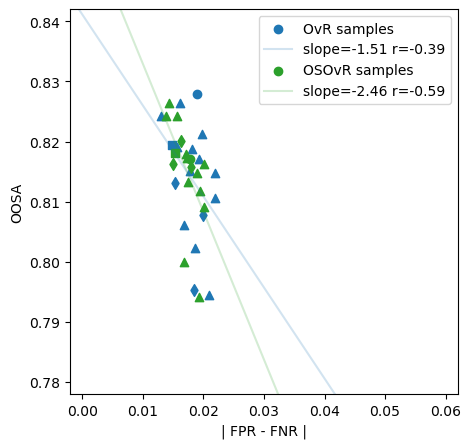

In [50]:

bump = 0.002
span = 0.06 + bump * 2
ystart = 0.78 - bump
xstart = 0 - bump
marker = ['o'] + ['^']*12 + ['d']*3 + ['s']

res_ovr_oosa = [res['oosa_unkn'] for res in res_ovr['oosa']]
res_osovr_oosa = [res['oosa_unkn'] for res in res_osovr['oosa']]


plt.figure(figsize=(5,5))
for i in range(len(res_ovr_oosa)):
    if i == 0:
        plt.scatter(res_ovr_fpr_fnr[i], res_ovr_oosa[i], label='OvR samples', marker=marker[i], c=CMAP[0])
    else:
        plt.scatter(res_ovr_fpr_fnr[i], res_ovr_oosa[i], marker=marker[i], c=CMAP[0])

res = stats.linregress(res_ovr_fpr_fnr, res_ovr_oosa)
line = f'slope={res.slope:.2f} r={res.rvalue:.2f}'
x = np.linspace(xstart, xstart+span, 10)
plt.plot(x, res.intercept + res.slope * x, label=line, c=CMAP[0], alpha=0.2)

for i in range(len(res_osovr_oosa)):
    if i == 0:
        plt.scatter(res_osovr_fpr_fnr[i], res_osovr_oosa[i], label='OSOvR samples', marker=marker[i], c=CMAP[2])
    else:
        plt.scatter(res_osovr_fpr_fnr[i], res_osovr_oosa[i], marker=marker[i], c=CMAP[2])

res = stats.linregress(res_osovr_fpr_fnr, res_osovr_oosa)
line = f'slope={res.slope:.2f} r={res.rvalue:.2f}'
x = np.linspace(xstart, xstart+span, 10)
plt.plot(x, res.intercept + res.slope * x, label=line, c=CMAP[2], alpha=0.2)

plt.legend(loc='upper right')

plt.xlim(xstart, xstart+span)
plt.ylim(ystart, ystart+span)
plt.xlabel('| FPR - FNR |')
plt.ylabel('OOSA')
plt.show()

### Summary

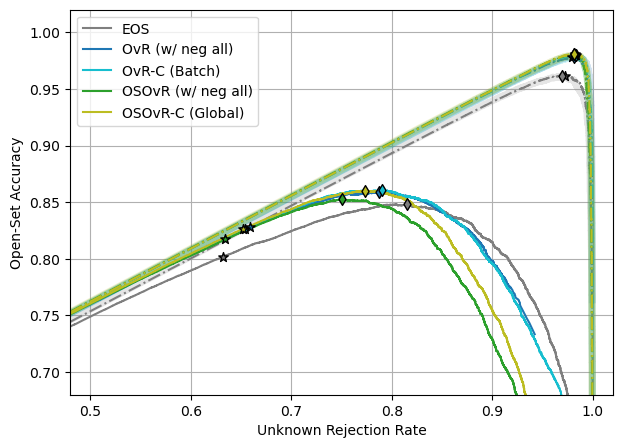

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.9774	0.9990	0.9059	0.9609	0.9613	0.8018	0.9619	0.8483
0.9931	0.9995	0.9121	0.9790	0.9778	0.8279	0.9780	0.8589
0.9928	0.9995	0.9176	0.9789	0.9799	0.8264	0.9801	0.8605
0.9939	0.9996	0.8921	0.9800	0.9804	0.8172	0.9805	0.8526
0.9931	0.9997	0.9006	0.9801	0.9808	0.8265	0.9813	0.8598


In [21]:
data_info = eos_data_info_1
data_info += ovr_data_info_2[-1:] + ovr_data_info_3_C[:1]
data_info += osovr_data_info_2[-1:] + osovr_data_info_3_C[-1:]
color = [CMAP[7],CMAP[0],CMAP[9],CMAP[2],CMAP[8],]

evals.plot_OSAC(data_info, color, figsize=(7,5), lim=((0.48,1.02),(0.68,1.02)))
res = evals.print_metrics(data_info)

### __ Feature space dimensionality

In [52]:
data_info = ovr_data_info_D + osovr_data_info_D
for idx in range(len(data_info)):
    print(idx, data_info[idx]['info'])

0 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F2C2', 'OvR']
1 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F2C5', 'OvR']
2 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F2C10', 'OvR']
3 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F3C3', 'OvR']
4 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F3C4', 'OvR']
5 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F2C2_neg_All', 'OvR']
6 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F2C5_neg_All', 'OvR']
7 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F2C10_neg_All', 'OvR']
8 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F3C3_neg_All', 'OvR']
9 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F3C4_neg_All', 'OvR']
10 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F2C2', 'OpenSetOvR']
11 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F2C5', 'OpenSetOvR']
12 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F2C10', 'OpenSetOvR']
13 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F3C3', 'OpenSetOvR']
14 ['SmallScale', '_Discussion', 'LeNet_plu

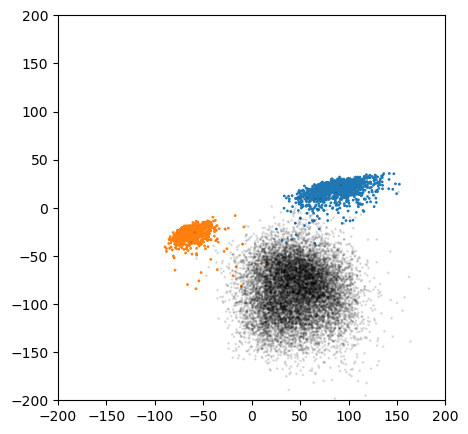

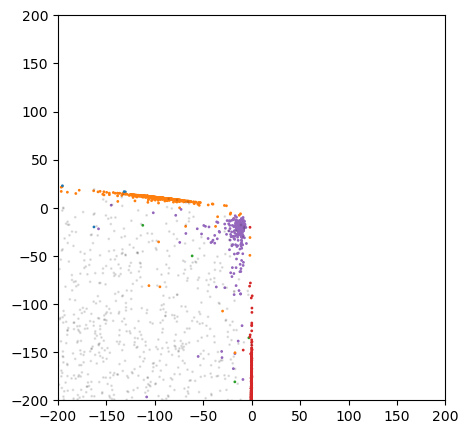

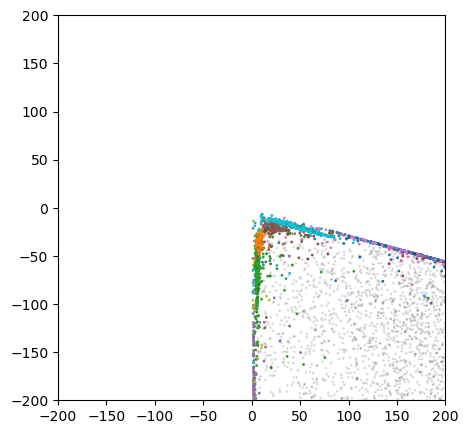

In [74]:
for i in [5,6,7]:
    plt.figure(figsize=(5,5))
    info = data_info[i]['info']

    root_path = f'/home/user/hkim/UZH-MT/openset-binary/_results/{info[0]}/_s42/{info[1]}/eval_{info[2]}/{info[3]}'
    eval_res = evals.eval_results(root_path, load_feats=True)

    val_gt = eval_res.val_gt
    val_feats = eval_res.val_feats
    pnt_color = [CMAP[gt] if gt != -1 else 'black' for gt in val_gt]
    pnt_alpha = [1 if gt != -1 else 0.1 for gt in val_gt]

    plt.scatter(val_feats[:,0], val_feats[:,1], color=pnt_color, s=1, alpha=pnt_alpha)
    plt.xlim((-200,200))
    plt.ylim((-200,200))

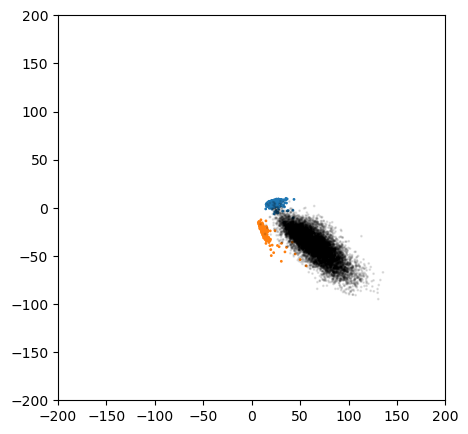

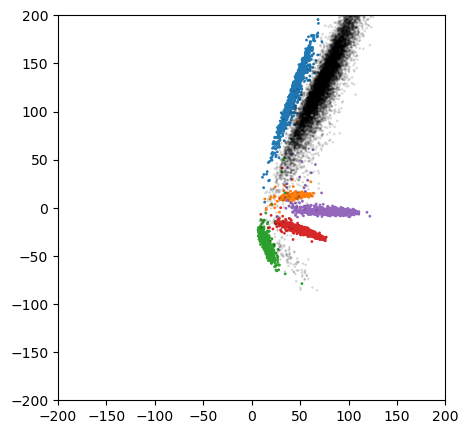

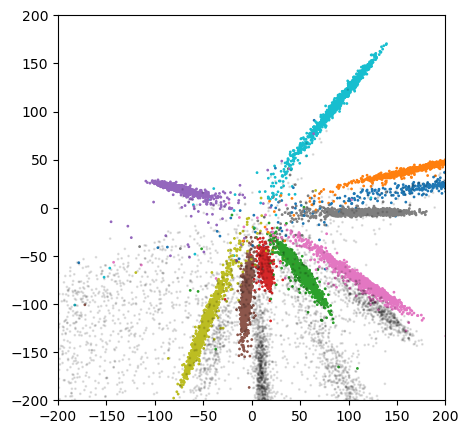

In [75]:
for i in [15,16,17]:
    plt.figure(figsize=(5,5))
    info = data_info[i]['info']

    root_path = f'/home/user/hkim/UZH-MT/openset-binary/_results/{info[0]}/_s42/{info[1]}/eval_{info[2]}/{info[3]}'
    eval_res = evals.eval_results(root_path, load_feats=True)

    val_gt = eval_res.val_gt
    val_feats = eval_res.val_feats
    pnt_color = [CMAP[gt] if gt != -1 else 'black' for gt in val_gt]
    pnt_alpha = [1 if gt != -1 else 0.1 for gt in val_gt]

    plt.scatter(val_feats[:,0], val_feats[:,1], color=pnt_color, s=1, alpha=pnt_alpha)
    plt.xlim((-200,200))
    plt.ylim((-200,200))

In [116]:
np.unique(val_gt)

array([-1,  0,  1,  2,  3])

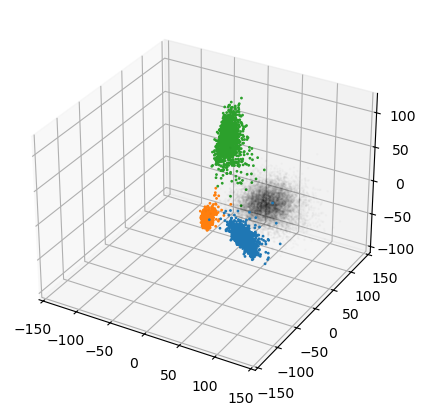

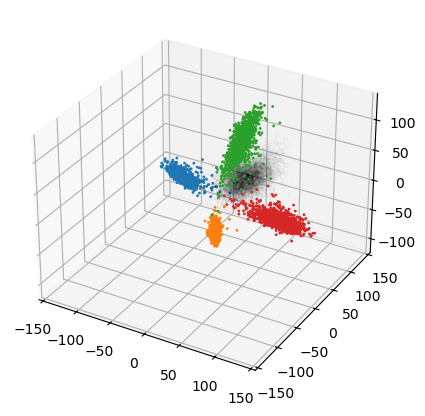

In [121]:
for i in [8,9]:
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(projection='3d')
    info = data_info[i]['info']

    root_path = f'/home/user/hkim/UZH-MT/openset-binary/_results/{info[0]}/_s42/{info[1]}/eval_{info[2]}/{info[3]}'
    eval_res = evals.eval_results(root_path, load_feats=True)

    val_gt = eval_res.val_gt
    val_feats = eval_res.val_feats
    pnt_color = [CMAP[gt] if gt != -1 else 'black' for gt in val_gt]
    pnt_alpha = [1 if gt != -1 else 0.1 for gt in val_gt]
    pnt_size = [1]*len(val_gt)

    for c in np.unique(val_gt):
        if c == -1:
            color = 'black'
            alpha = 0.01
        else:
            color = CMAP[c]
            alpha = 1
        ax.scatter(val_feats[val_gt==c,0], val_feats[val_gt==c,1], val_feats[val_gt==c,2],
                   color=color, alpha=alpha, s=1)

    # print(val_feats[:,0].shape, val_gt.shape)
    # ax.scatter(val_feats[:,0], val_feats[:,1], val_feats[:,2],)
    # ax.scatter(val_feats[:,0], val_feats[:,1], val_feats[:,2], 
    #            s=1)
    ax.set_xlim((-150,150))
    ax.set_ylim((-150,150))

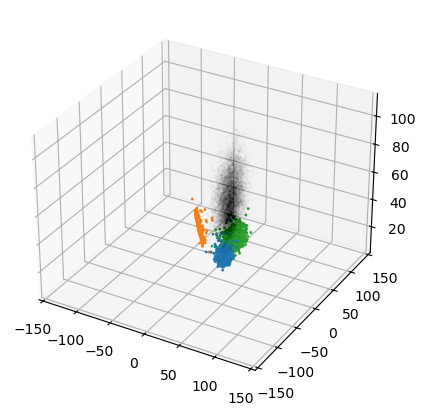

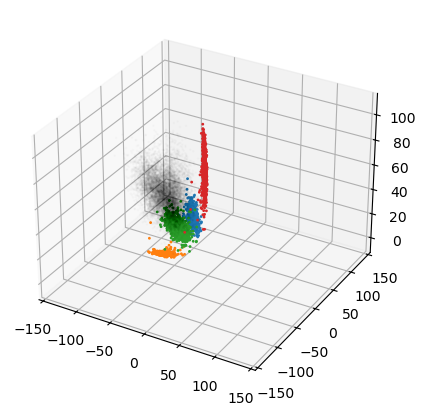

In [122]:
for i in [18,19]:
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(projection='3d')
    info = data_info[i]['info']

    root_path = f'/home/user/hkim/UZH-MT/openset-binary/_results/{info[0]}/_s42/{info[1]}/eval_{info[2]}/{info[3]}'
    eval_res = evals.eval_results(root_path, load_feats=True)

    val_gt = eval_res.val_gt
    val_feats = eval_res.val_feats
    pnt_color = [CMAP[gt] if gt != -1 else 'black' for gt in val_gt]
    pnt_alpha = [1 if gt != -1 else 0.1 for gt in val_gt]
    pnt_size = [1]*len(val_gt)

    for c in np.unique(val_gt):
        if c == -1:
            color = 'black'
            alpha = 0.01
        else:
            color = CMAP[c]
            alpha = 1
        ax.scatter(val_feats[val_gt==c,0], val_feats[val_gt==c,1], val_feats[val_gt==c,2],
                   color=color, alpha=alpha, s=1)

    # print(val_feats[:,0].shape, val_gt.shape)
    # ax.scatter(val_feats[:,0], val_feats[:,1], val_feats[:,2],)
    # ax.scatter(val_feats[:,0], val_feats[:,1], val_feats[:,2], 
    #            s=1)
    ax.set_xlim((-150,150))
    ax.set_ylim((-150,150))